In [1]:
import numpy as np
from tqdm import tqdm, trange
import itertools

import matplotlib.pyplot as plt

from SGA import SGA

ERROR! Session/line number was not unique in database. History logging moved to new session 8


## Zadanie 3.
Spróbuj ulepszyć algorytm ewolucyjny z Zadania 1 wprowadzając dodatkową mutację polegającą na przeszukiwaniu lokalnym (dla danej permutacji początkowej, sprawdzamy wszystkie permutacje różniące się od niej na nie więcej niż K pozycjach i permutację początkową zamieniamy na najlepszą znalezioną) i iterowanym przeszukiwaniu lokalnym (dla danej permutacji początkowej, sprawdzamy wszystkie permutacje różniące się od niej na nie więcej niż K pozycjach, permutację początkową zamieniamy na najlepszą znalezioną i powtarzamy procedurę dopóki możliwa jest poprawa rozwiązania).

In [2]:
def gen_2perms(perm):
    all_perms = np.array([perm])
    for i in range(len(perm)):
        for j in range(len(perm)):
            if i == j:
                continue
                
            p = perm.copy()
            p[i], p[j] = p[j], p[i]
            all_perms = np.vstack((all_perms, p))
    return all_perms[1:]

def compute_dists(coords, n):
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
    return A

def mutation_local_search(perm, K, objective_func, dists):
    last_perms = [perm]
    all_perms = [perm]
    for _ in range(2, K+1):
        last_perms = np.array(list(map(lambda p: gen_2perms(p), last_perms))).reshape(-1, len(perm))
        all_perms = np.vstack((all_perms, last_perms))
    
    all_perms = all_perms[np.count_nonzero(all_perms != perm, axis=1) <= K]
    objective_values = np.array(list(map(lambda ind: objective_func(ind, dists), all_perms)))
    
    return all_perms[objective_values.argmin()]

In [3]:
def tsp_objective_function(p, dist):
    s = 0.0
    for i in range(n):
        s += dist[p[i-1], p[i]]
    return s

def PMX(ind1, ind2, separator_no=2):
    new_ind1, new_ind2 = ind1.copy(), ind2.copy()
    idxs = sorted(np.random.choice(len(ind1), separator_no, replace=False))
    
    group = np.random.choice(separator_no-1)
    start, end = idxs[group], idxs[group+1]
    
    tmp = ind1[start:end].copy()
    ind1[start:end] = ind2[start:end]
    ind2[start:end] = tmp
    
    for i in range(len(ind1)):
        if start <= i < end:
            continue
            
        while ind1[i] in ind1[start:end]:
            # get elem from the other ind
            idx_of_elem = np.nonzero(ind1[start:end] == ind1[i])[0][0]
            ind1[i] = ind2[start+idx_of_elem]
        
        while ind2[i] in ind2[start:end]:
            # get elem from the other ind
            idx_of_elem = np.nonzero(ind2[start:end] == ind2[i])[0][0]
            ind2[i] = ind1[start+idx_of_elem]

    return ind1, ind2

In [4]:
def reverse_sequence_mutation(p, *args):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q


def mutation_function(perm, *args):
    perm = reverse_sequence_mutation(perm)
    return mutation_local_search(perm, K, tsp_objective_function, dists)

In [5]:
def iterative_mutation_function(perm, *args):
    perm = reverse_sequence_mutation(perm)
    
    best_perm = perm
    prev_best_perm = None
    
    while np.count_nonzero(best_perm != prev_best_perm):
        prev_best_perm = best_perm
        best_perm = mutation_local_search(best_perm, K, tsp_objective_function, dists)
    
    return best_perm

#### Bays29

In [37]:
n = 29
number_of_iters=100

data = open('data.nogit/bays29.tsp').read()
dists = np.zeros((n, n))
for i, row in enumerate(data.split('\n')[8:37]):
    dists[i] = list(map(int, row.split()))

In [38]:
K = 2

sga = SGA(population_size=500, chromosome_length=n, crossover_func=PMX, objective_func=tsp_objective_function,
             distance_matrix=dists, mutation_func=mutation_function, replace_method='mu+lambda',
             number_of_offspring=500, crossover_probability=0.95, mutation_probability=0.25, 
             number_of_iterations=number_of_iters)

sga.run(with_tqdm=True)

100%|██████████| 100/100 [05:30<00:00,  3.30s/it]


Best for SGA with local search: 2060.0, global min: 1498


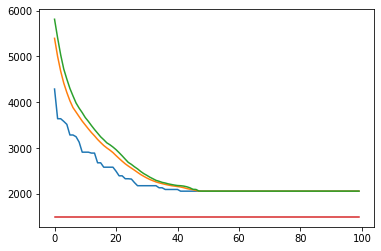

In [39]:
loc_search_cost = sga.mean_costs
print(f'Best for SGA with local search: {sga.min_costs.min()}, global min: {1498}')
plt.plot(sga.min_costs)
plt.plot(sga.mean_costs)
plt.plot(sga.max_costs)
plt.plot(np.full(number_of_iters, 1498))
plt.show()

In [40]:
K = 2
number_of_iters=50

sga = SGA(population_size=500, chromosome_length=n, crossover_func=PMX, objective_func=tsp_objective_function,
             distance_matrix=dists, mutation_func=iterative_mutation_function, replace_method='mu+lambda',
             number_of_offspring=500, crossover_probability=0.95, mutation_probability=0.25, 
             number_of_iterations=number_of_iters)

sga.run(with_tqdm=True)

100%|██████████| 50/50 [14:58<00:00, 17.98s/it]


Best for SGA with iterative local search: 2020.0, global min: 1498


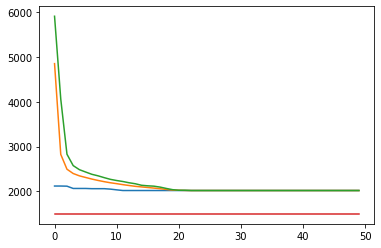

In [41]:
iter_loc_search_cost = sga.mean_costs
print(f'Best for SGA with iterative local search: {sga.min_costs.min()}, global min: {1498}')
plt.plot(sga.min_costs)
plt.plot(sga.mean_costs)
plt.plot(sga.max_costs)
plt.plot(np.full(number_of_iters, 1498))
plt.show()